In [1]:
import functools
import os
import pickle
import random

import numpy as np
import pandas as pd
import scipy.stats as st
import seaborn as sns
import statsmodels.formula.api as smf
from matplotlib import pyplot as plt


@functools.wraps(smf.ols)
def lm(*args, **kwargs):
    return smf.ols(*args, **kwargs).fit()

In [2]:
np.random.seed(0)

In [3]:
os.chdir("../../data")

In [4]:
recommendee = "Fro116"

In [5]:
raw_df = pd.read_csv("UserAnimeList.csv")

In [6]:
filtered_df = raw_df[["username", "anime_id", "my_score"]].loc[
    lambda x: x["my_score"] != 0
]

In [7]:
# add additional user anime-lists
extraUsers = pickle.load(open("user_profiles/ExtraUserAnimeLists.pkl", "rb"))
filtered_df = filtered_df.loc[lambda x: ~x["username"].isin(extraUsers.username)]
filtered_df = pd.concat([filtered_df, extraUsers], ignore_index=True)

In [8]:
average_rating = filtered_df["my_score"].mean()
user_bias = (
    pd.DataFrame(filtered_df.groupby("username")["my_score"].mean()).rename(
        {"my_score": "user_bias"}, axis=1
    )
    - average_rating
)
anime_bias = (
    pd.DataFrame(filtered_df.groupby("anime_id")["my_score"].mean()).rename(
        {"my_score": "anime_bias"}, axis=1
    )
    - average_rating
)

In [9]:
filtered_df = filtered_df.merge(anime_bias, on=["anime_id"]).merge(
    user_bias, on=["username"]
)
filtered_df["normalized_score"] = (
    filtered_df["my_score"]
    - filtered_df["anime_bias"]
    - filtered_df["user_bias"]
    - average_rating
)
filtered_df["orig_normalized_score"] = filtered_df["normalized_score"]
filtered_df = filtered_df.set_index("username")
filtered_df = filtered_df.dropna()

In [10]:
def prepare_prediction(recommendee, neighborhood):
    pred_df = pd.DataFrame()
    pred_df["delta"] = neighborhood.groupby("anime_id").apply(
        lambda x: np.dot(x["normalized_score"], x["corr"]) / x["corr"].abs().sum()
    )
    pred_df["blp"] = anime_bias + user_bias.loc[recommendee].squeeze() + average_rating
    pred_df = pred_df.dropna()
    return pred_df

In [11]:
def get_squared_error(df, pred_df, recommendee):
    recommendee_df = pred_df.loc[
        pred_df.index.intersection(df.loc[recommendee].anime_id)
    ]
    recommendee_df = recommendee_df.merge(
        df.loc[recommendee].set_index("anime_id")["my_score"], on="anime_id"
    )
    errors = recommendee_df["my_score"] - recommendee_df["score"]
    return np.dot(errors, errors)

In [12]:
filtered_df.head()

,anime_id,my_score,anime_bias,user_bias,normalized_score,orig_normalized_score
username,,,,,,
karthiga,21,9,0.960564,-0.059898,0.605474,0.605474
karthiga,59,7,0.040203,-0.059898,-0.474165,-0.474165
karthiga,74,7,0.316282,-0.059898,-0.750245,-0.750245
karthiga,120,7,0.309858,-0.059898,-0.743821,-0.743821
karthiga,178,7,-0.227339,-0.059898,-0.206624,-0.206624


In [13]:
all_corrs = pickle.load(open("item_correlations/correlations.pkl", "rb"))
all_corrs["similarity"] = all_corrs["corr"].abs()
all_corrs = all_corrs.dropna()
all_corrs = all_corrs.loc[
    lambda x: x.index.get_level_values("anime_id_x")
    != x.index.get_level_values("anime_id_y")
]
all_corrs = all_corrs.sort_values(by="similarity")
all_corrs_nonneg = all_corrs.sort_values(by="corr")

In [14]:
def compute_accuracy_metrics(
    is_df, oos_df, corrs, recommendee, neighborhood_sizes, nonneg_corrs
):
    anime_var = (
        pd.DataFrame(is_df.groupby("anime_id")["normalized_score"].var())
        .rename({"normalized_score": "anime_var"}, axis=1)
        .dropna()
    )
    user_var = (
        pd.DataFrame(is_df.groupby("username")["normalized_score"].var())
        .rename({"normalized_score": "user_var"}, axis=1)
        .dropna()
    )

    metrics = pd.DataFrame()
    for neighborhood_size in reversed(sorted(neighborhood_sizes)):
        # extract model features
        corrs = corrs.groupby("anime_id_x").tail(neighborhood_size)

        score = is_df.loc[recommendee].merge(
                corrs.reset_index("anime_id_x"),
                left_on="anime_id",
                right_on="anime_id_y",
            )
        score["user_var"] = user_var.loc[recommendee].squeeze()
        score = score.merge(anime_var, on="anime_id")
        score = score.drop("anime_id", axis=1).rename(
                {"anime_id_x": "anime_id"}, axis=1
            )
        pred_df = prepare_prediction(recommendee, score)

        # train linear model
        recomendee_seen_shows = is_df.loc[recommendee].merge(pred_df, on=["anime_id"])
        recomendee_seen_shows["target"] = (
            recomendee_seen_shows["my_score"] - recomendee_seen_shows["blp"]
        )
        model = lm("target ~ delta + 0", recomendee_seen_shows)

        # inference
        pred_df["score"] = model.predict(pred_df) + pred_df["blp"]
        is_pred_df = pred_df.loc[
            lambda x: x.index.isin(is_df.loc[recommendee].anime_id)
        ]
        oos_pred_df = pred_df.loc[lambda x: x.index.isin(oos_df.anime_id)]

        # compute coverage
        is_coverage = len(is_pred_df) / len(is_df.loc[recommendee])
        oos_coverage = len(oos_pred_df) / len(oos_df)

        # compute rmse
        missing_is = is_df.loc[recommendee].loc[
            lambda x: ~x.anime_id.isin(is_pred_df.index)
            & ~x.anime_id.isin(oos_df.anime_id)
        ]
        missing_oos = oos_df.loc[lambda x: ~x.anime_id.isin(oos_pred_df.index)]
        is_se = get_squared_error(is_df, is_pred_df, recommendee)
        oos_se = get_squared_error(oos_df, oos_pred_df, recommendee)
        missing_is_se = np.dot(
            missing_is["orig_normalized_score"], missing_is["orig_normalized_score"]
        )
        missing_oos_se = np.dot(
            missing_oos["orig_normalized_score"], missing_oos["orig_normalized_score"]
        )
        is_rmse = np.sqrt((is_se + missing_is_se) / len(is_df.loc[recommendee]))
        oos_rmse = np.sqrt((oos_se + missing_oos_se) / len(oos_df))
        metrics = metrics.append(
            {
                "neighborhood_size": neighborhood_size,
                "nonneg_corrs": nonneg_corrs,
                "is_rmse": is_rmse,
                "is_coverage": is_coverage,
                "oos_rmse": oos_rmse,
                "oos_coverage": oos_coverage,
            },
            ignore_index=True,
        )

    return metrics

In [15]:
%%time
from tqdm import tqdm

K = 10
base = np.sqrt(2)

errors_by_neighborhood_size = []
max_size = len(filtered_df.anime_id.unique())
neighborhood_sizes = [
    int(base ** i) for i in range(int(np.log(max_size) / np.log(base)) + 1)
] + [max_size]
neighborhood_sizes = sorted(list(set(neighborhood_sizes)))
splits = np.array_split(filtered_df.loc[recommendee].sample(frac=1), K)
for split in splits:
    display(split.head())

for split in tqdm(splits):
    oos_df = split
    is_df = filtered_df.loc[
        lambda x: ~(
            (x.index.get_level_values("username") == recommendee)
            & x.anime_id.isin(oos_df.anime_id)
        )
    ]
    # we take copies as a safety precaution
    errors_by_neighborhood_size.append(
        compute_accuracy_metrics(
            is_df.copy(),
            oos_df.copy(),
            all_corrs.copy(),
            recommendee,
            neighborhood_sizes,
            False,
        )
    )
    errors_by_neighborhood_size.append(
        compute_accuracy_metrics(
            is_df.copy(),
            oos_df.copy(),
            all_corrs_nonneg.copy(),
            recommendee,
            neighborhood_sizes,
            True,
        )
    )    

,anime_id,my_score,anime_bias,user_bias,normalized_score,orig_normalized_score
username,,,,,,
Fro116,3231,5,-0.313608,-1.113163,-1.067089,-1.067089
Fro116,16662,6,0.631140,-1.113163,-1.011837,-1.011837
Fro116,8129,4,0.710679,-1.113163,-3.091376,-3.091376
Fro116,1251,6,0.039136,-1.113163,-0.419833,-0.419833
Fro116,5196,6,-0.278286,-1.113163,-0.102411,-0.102411


,anime_id,my_score,anime_bias,user_bias,normalized_score,orig_normalized_score
username,,,,,,
Fro116,10719,7,0.019630,-1.113163,0.599673,0.599673
Fro116,7193,6,0.365592,-1.113163,-0.746289,-0.746289
Fro116,13659,7,-0.105101,-1.113163,0.724404,0.724404
Fro116,32281,8,1.583045,-1.113163,0.036258,0.036258
Fro116,199,6,1.329722,-1.113163,-1.710419,-1.710419


,anime_id,my_score,anime_bias,user_bias,normalized_score,orig_normalized_score
username,,,,,,
Fro116,390,5,-0.198094,-1.113163,-1.182603,-1.182603
Fro116,22101,6,0.185061,-1.113163,-0.565758,-0.565758
Fro116,10408,4,1.034426,-1.113163,-3.415123,-3.415123
Fro116,9760,6,0.210068,-1.113163,-0.590765,-0.590765
Fro116,34445,10,0.108697,-1.113163,3.510606,3.510606


,anime_id,my_score,anime_bias,user_bias,normalized_score,orig_normalized_score
username,,,,,,
Fro116,2476,8,-1.294578,-1.113163,2.913881,2.913881
Fro116,38790,6,-1.493860,-1.113163,1.113163,1.113163
Fro116,35839,6,0.939939,-1.113163,-1.320636,-1.320636
Fro116,33836,6,-1.344841,-1.113163,0.964144,0.964144
Fro116,32949,6,-0.051486,-1.113163,-0.329211,-0.329211


,anime_id,my_score,anime_bias,user_bias,normalized_score,orig_normalized_score
username,,,,,,
Fro116,4382,8,-0.352281,-1.113163,1.971584,1.971584
Fro116,35968,5,0.386392,-1.113163,-1.767089,-1.767089
Fro116,12893,6,0.307927,-1.113163,-0.688624,-0.688624
Fro116,11757,7,0.064214,-1.113163,0.555089,0.555089
Fro116,35848,6,-1.493860,-1.113163,1.113163,1.113163


,anime_id,my_score,anime_bias,user_bias,normalized_score,orig_normalized_score
username,,,,,,
Fro116,237,7,0.620344,-1.113163,-0.001041,-0.001041
Fro116,10357,5,0.281511,-1.113163,-1.662208,-1.662208
Fro116,16201,8,-0.752654,-1.113163,2.371957,2.371957
Fro116,38691,6,-1.493860,-1.113163,1.113163,1.113163
Fro116,82,8,0.281788,-1.113163,1.337515,1.337515


,anime_id,my_score,anime_bias,user_bias,normalized_score,orig_normalized_score
username,,,,,,
Fro116,10793,5,0.044382,-1.113163,-1.425079,-1.425079
Fro116,33161,8,0.598972,-1.113163,1.020331,1.020331
Fro116,6114,4,0.962409,-1.113163,-3.343106,-3.343106
Fro116,519,6,-0.034179,-1.113163,-0.346518,-0.346518
Fro116,3466,8,0.152112,-1.113163,1.467191,1.467191


,anime_id,my_score,anime_bias,user_bias,normalized_score,orig_normalized_score
username,,,,,,
Fro116,9756,10,0.981339,-1.113163,2.637964,2.637964
Fro116,2236,5,0.971346,-1.113163,-2.352043,-2.352043
Fro116,5681,7,0.818492,-1.113163,-0.199189,-0.199189
Fro116,24629,5,-0.792548,-1.113163,-0.588149,-0.588149
Fro116,31376,6,0.068291,-1.113163,-0.448988,-0.448988


,anime_id,my_score,anime_bias,user_bias,normalized_score,orig_normalized_score
username,,,,,,
Fro116,9617,8,0.880099,-1.113163,0.739204,0.739204
Fro116,15911,5,-0.176364,-1.113163,-1.204333,-1.204333
Fro116,17895,5,0.233372,-1.113163,-1.614069,-1.614069
Fro116,387,8,0.544611,-1.113163,1.074691,1.074691
Fro116,1915,8,0.266326,-1.113163,1.352977,1.352977


,anime_id,my_score,anime_bias,user_bias,normalized_score,orig_normalized_score
username,,,,,,
Fro116,24913,8,0.155350,-1.113163,1.463953,1.463953
Fro116,39195,8,1.006140,-1.113163,0.613163,0.613163
Fro116,6547,6,0.811400,-1.113163,-1.192097,-1.192097
Fro116,31646,7,0.753427,-1.113163,-0.134124,-0.134124
Fro116,1124,5,-0.256873,-1.113163,-1.123824,-1.123824


100%|██████████| 10/10 [3:42:52<00:00, 1337.29s/it] 

CPU times: user 1h 55min 51s, sys: 1h 9min 46s, total: 3h 5min 38s
Wall time: 3h 42min 58s


In [16]:
allerrors = pd.concat(errors_by_neighborhood_size, ignore_index=True)

In [17]:
allerrors

,is_coverage,is_rmse,neighborhood_size,nonneg_corrs,oos_coverage,oos_rmse
0,0.910448,1.558454,14090.0,0.0,0.973684,1.382892
1,0.910448,1.558386,11585.0,0.0,0.973684,1.382934
2,0.910448,1.557595,8192.0,0.0,0.973684,1.386351
3,0.910448,1.557277,5792.0,0.0,0.973684,1.381938
4,0.910448,1.560169,4096.0,0.0,0.973684,1.371331
...,...,...,...,...,...,...
535,0.797619,1.560802,8.0,1.0,0.783784,1.528053
536,0.729167,1.581444,5.0,1.0,0.756757,1.562107
537,0.699405,1.573454,4.0,1.0,0.756757,1.554923
538,0.574405,1.593280,2.0,1.0,0.675676,1.663179


In [18]:
wide_data = pd.melt(allerrors, ["neighborhood_size", "nonneg_corrs"])

In [19]:
wide_data.loc[lambda x: x.nonneg_corrs == True, "variable"] = (
    "nonneg_" + wide_data.loc[lambda x: x.nonneg_corrs == True, "variable"]
)

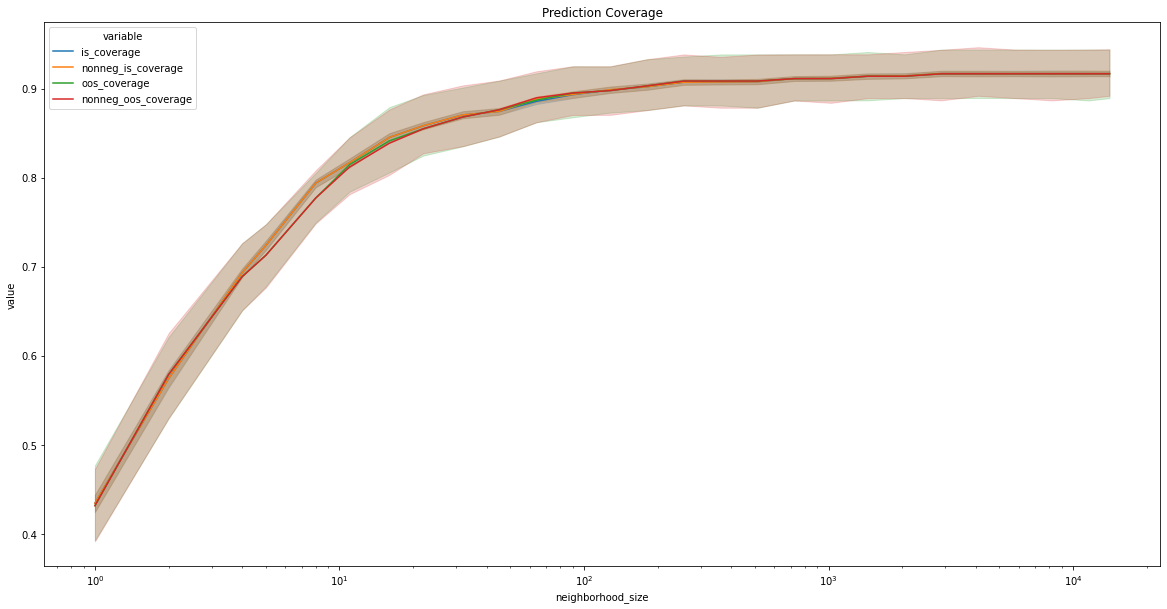

In [20]:
plt.figure(figsize=(20, 10))
_ = sns.lineplot(
    x="neighborhood_size",
    y="value",
    hue="variable",
    data=wide_data.loc[lambda x: x.variable.str.contains("coverage")],
).set(xscale="log", title="Prediction Coverage")

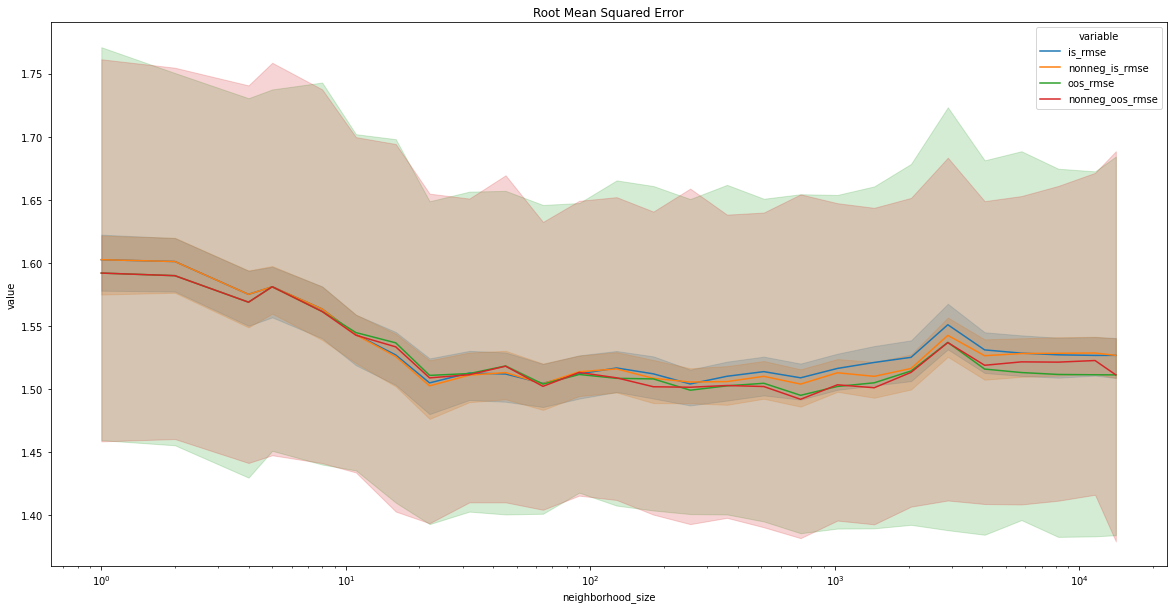

In [21]:
plt.figure(figsize=(20, 10))
_ = sns.lineplot(
    x="neighborhood_size",
    y="value",
    hue="variable",
    data=wide_data.loc[lambda x: x.variable.str.contains("rmse")],
).set(xscale="log", title="Root Mean Squared Error")

In [22]:
pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)
pd.set_option("display.width", 1000)
allerrors.groupby(["nonneg_corrs", "neighborhood_size"]).mean().sort_values(
    by="oos_rmse"
).head(10)

is_coverage   is_rmse  oos_coverage  oos_rmse
nonneg_corrs neighborhood_size                                               
1.0          724.0                 0.911225  1.503903      0.911095  1.491862
0.0          724.0                 0.911225  1.508885      0.911095  1.494997
             256.0                 0.907056  1.504010      0.908393  1.499064
1.0          1448.0                0.913905  1.510041      0.913798  1.501005
             256.0                 0.907056  1.505543      0.908393  1.501403
             181.0                 0.901990  1.508489      0.902987  1.501799
             512.0                 0.907651  1.510061      0.908393  1.501975
0.0          1024.0                0.911523  1.516321      0.911095  1.502052
1.0          64.0                  0.887991  1.504172      0.889616  1.502120
0.0          362.0                 0.907353  1.510106      0.908393  1.502524

In [23]:
pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)
pd.set_option("display.width", 1000)
allerrors.groupby(["nonneg_corrs", "neighborhood_size"]).mean().xs(
    0, level="nonneg_corrs"
).sort_values(by="oos_rmse").head(10)

,is_coverage,is_rmse,oos_coverage,oos_rmse
neighborhood_size,,,,
724.0,0.911225,1.508885,0.911095,1.494997
256.0,0.907056,1.504010,0.908393,1.499064
1024.0,0.911523,1.516321,0.911095,1.502052
362.0,0.907353,1.510106,0.908393,1.502524
64.0,0.885608,1.504498,0.886913,1.503895
512.0,0.907651,1.513773,0.908393,1.504542
1448.0,0.913905,1.521064,0.913798,1.504928
181.0,0.901990,1.512033,0.902987,1.508003
128.0,0.898416,1.516686,0.897653,1.508478
